#### Import libraries

In [28]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import pickle
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
import random
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Creating the model for the classifier

### Load and visualize the training images

Read in all the data

In [29]:
notcars = glob.glob('data\\non-vehicles\\*.png', recursive=True)
cars = glob.glob('data\\vehicles\\*.png', recursive=True)

#### Visualize sample images for car and not car types

In [30]:
def visualize_images(input_images, num_cols, figure_name, cmap = None):
    "Shows input images by stacking them in num_cols columns"
    fig, axes = plt.subplots((int)((len(input_images) + 1) /num_cols), num_cols, figsize=(24, 20))

    fig = plt.gcf()
    fig.canvas.set_window_title(figure_name)
    
    print(figure_name)
    for ax, image in zip(axes.flat, input_images):
        
        if(cmap == "gray" or cmap == 'hot'):
            ax.imshow(image, cmap=cmap)
        elif(image.shape[2]==1):
            ax.imshow(image[:,:,0], cmap = cmap)
        else:
            ax.imshow(image, cmap=cmap)
    plt.savefig('output_images\\'+figure_name+'.png')
    plt.show()

Example Car images


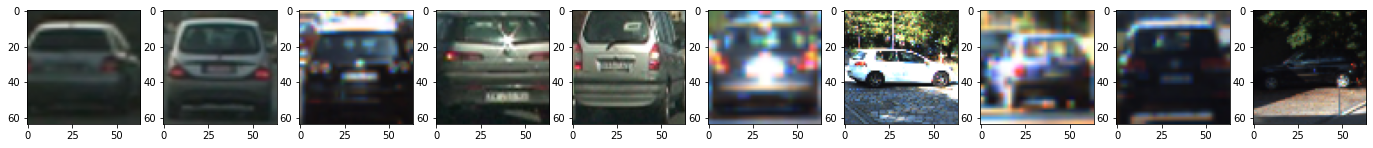

Example not-car images


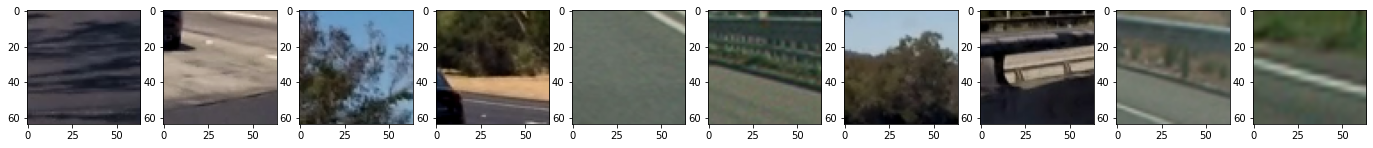

In [31]:
#Visualize some input images

num_images = 10

# Just for fun choose random car / not-car indices and plot example images   
cars_samples = random.sample(list(cars), num_images)
notcar_samples = random.sample(list(notcars), num_images)
    
# Read in car / not-car images
car_images = []
notcar_images = []

for car, notcar  in zip(cars_samples, notcar_samples):
    car_images.append(mpimg.imread(car))
    notcar_images.append(mpimg.imread(notcar))
    
visualize_images(car_images, num_images, "Example Car images")
visualize_images(notcar_images, num_images, "Example not-car images")

#### Load  Classes

In [44]:
# %load HogClasses.py

In [45]:
obj_image_processor_svc = ImageProcessingSVC()

### Train the classifier on the features
Convert the images to feature vectors and normalize the feature vectors

In [46]:
car_features = obj_image_processor_svc.extract_features(cars, color_space='LUV', 
                        spatial_size=(32, 32), hist_bins=32, 
                        orient=9, pix_per_cell=8, 
                        cell_per_block=2, 
                        hog_channel="ALL", spatial_feat= True, 
                        hist_feat=True, hog_feat=True)
notcar_features = obj_image_processor_svc.extract_features(notcars, color_space='LUV', 
                        spatial_size=(32, 32), hist_bins=32, 
                        orient=9, pix_per_cell=8, 
                        cell_per_block=2, 
                        hog_channel="ALL", spatial_feat= True, 
                        hist_feat=True, hog_feat=True)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

### Build & train the classifer

Shuffle the data and segment into training and test splits

In [48]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


#### Initalize & train the classifier

In [49]:
# Use a linear SVC 
svc = LinearSVC() 
# Check the training time for the SVC
svc.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.989


save the classifier

In [ ]:
with open('Vehicle_Detection_SVC.pkl', 'wb') as fid:
    pickle.dump([svc, X_scaler], fid)

Load the classifier and scaler using pickle

In [34]:
with open('Vehicle_Detection_SVC.pkl', 'rb') as fid:
    svc, X_scaler = pickle.load(fid)

## Detect vehicles on the test images

In [35]:
processor = processDataSVC(svc, X_scaler)

#### Read in all the test images

Test images shape is: (4, 720, 1280, 3)


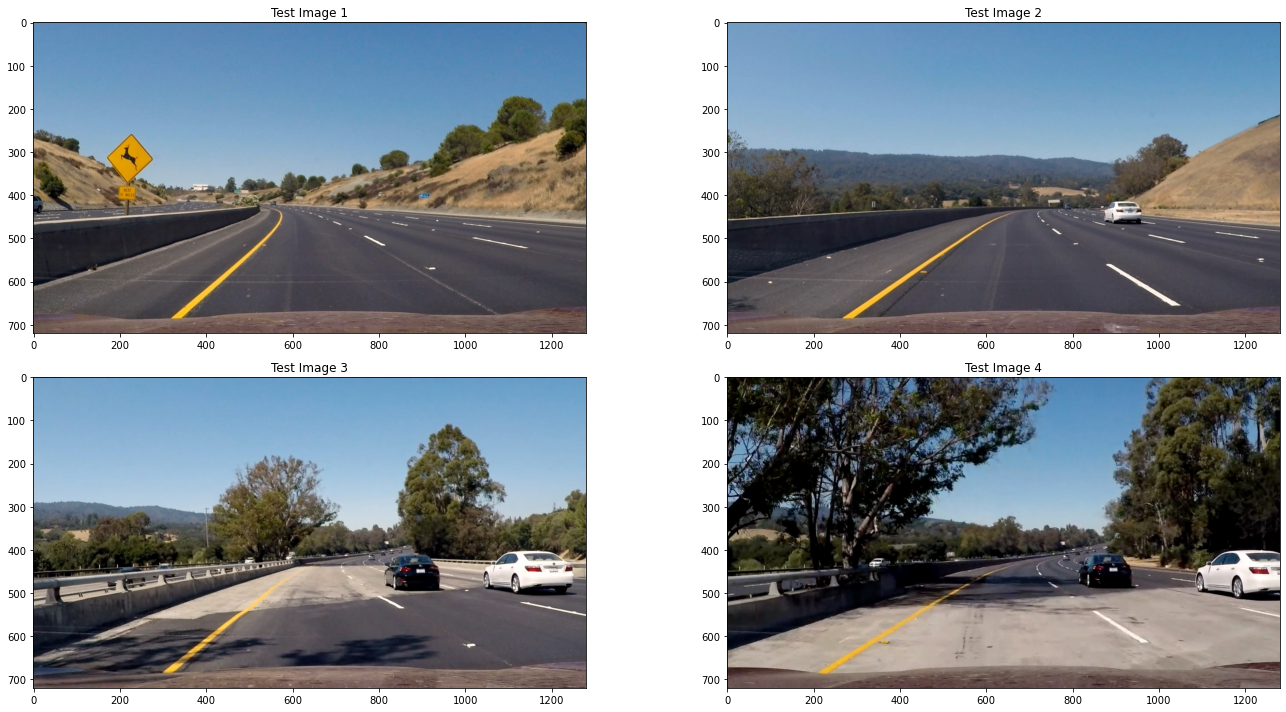

In [36]:
test_images = processor.read_and_show_test_image('test_images\*.jpg')

Visualize the windows on each test image

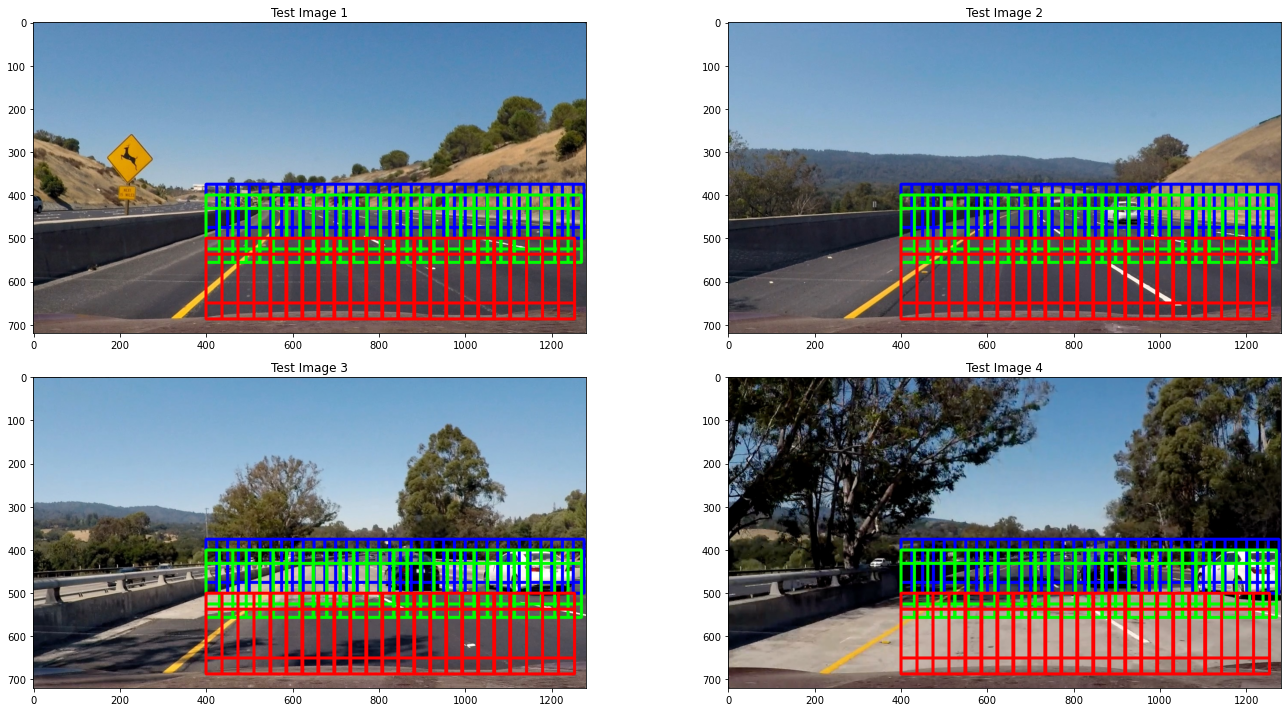

In [37]:
processor.view_windows(test_images)

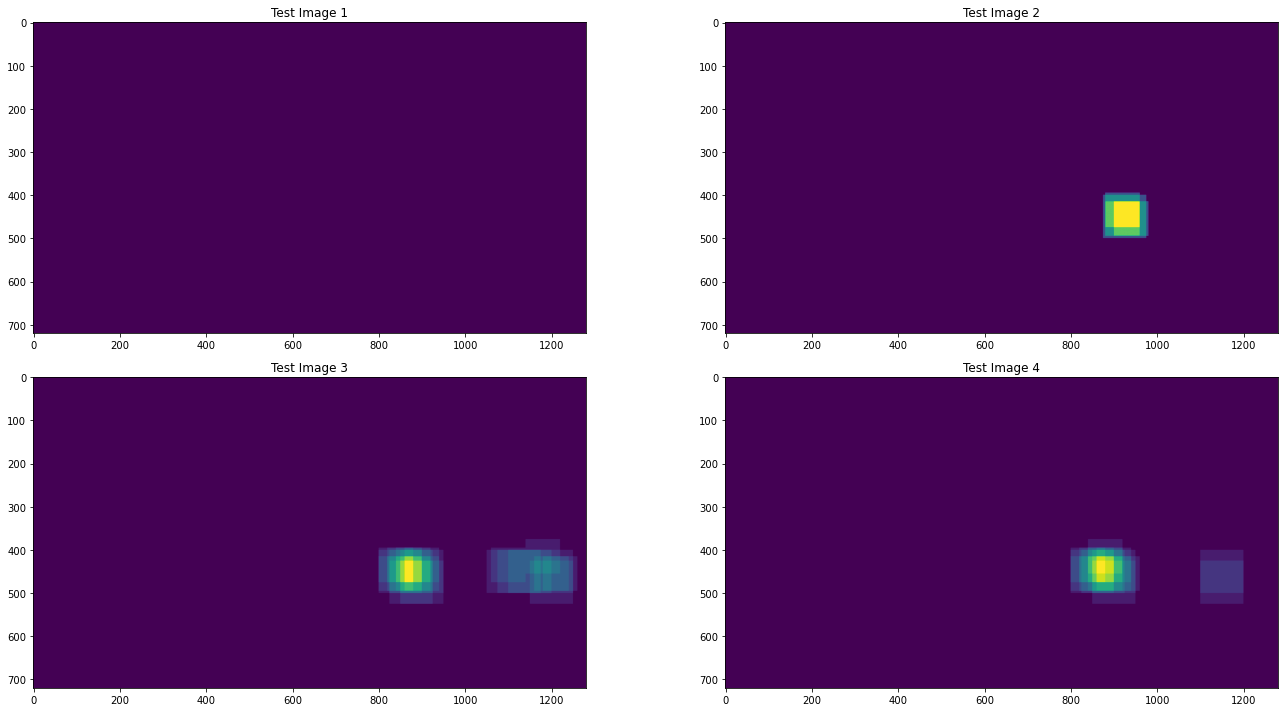

In [38]:
processor.visual_box(test_images, 'heatmap', 'SVC')

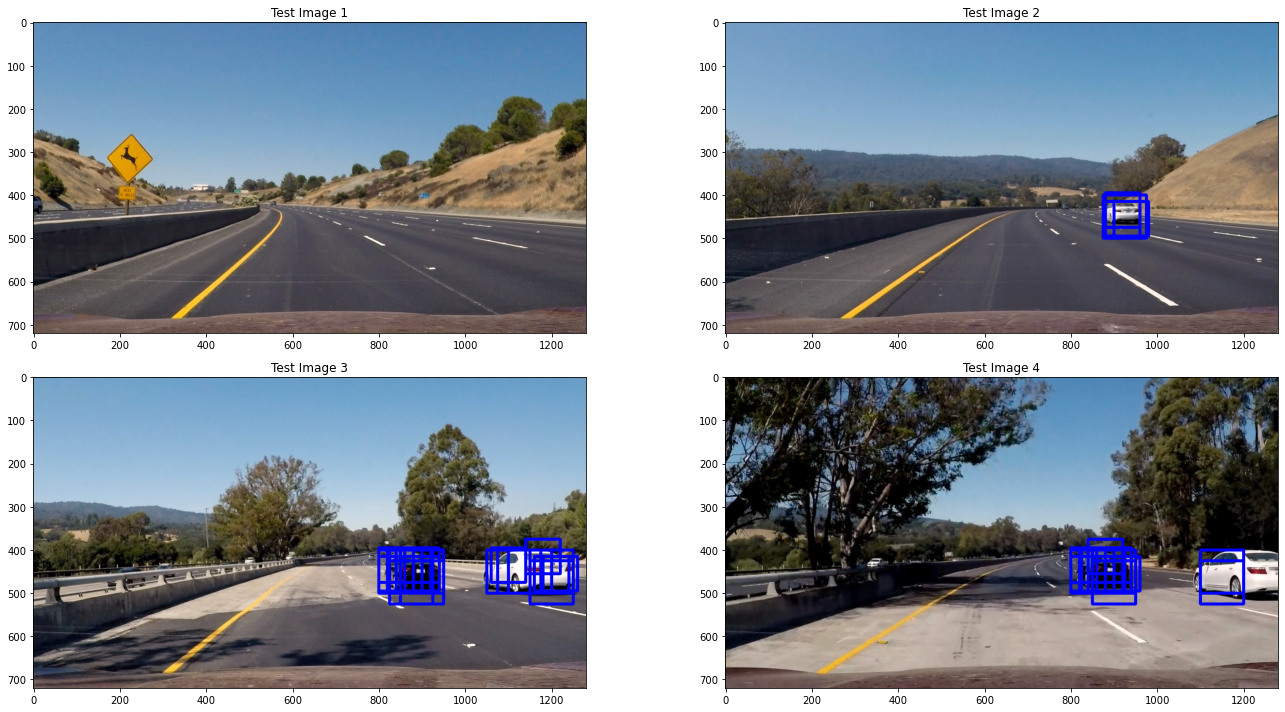

In [39]:
processor.visual_box(test_images,'boxes', 'SVC')

object_id: 0
bbox0: (875, 395)
bbox1: (979, 499)

object_id: 0
bbox0: (1050, 375)
bbox1: (1259, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (949, 524)

object_id: 0
bbox0: (800, 375)
bbox1: (959, 524)

object_id: 1
bbox0: (1100, 400)
bbox1: (1199, 524)



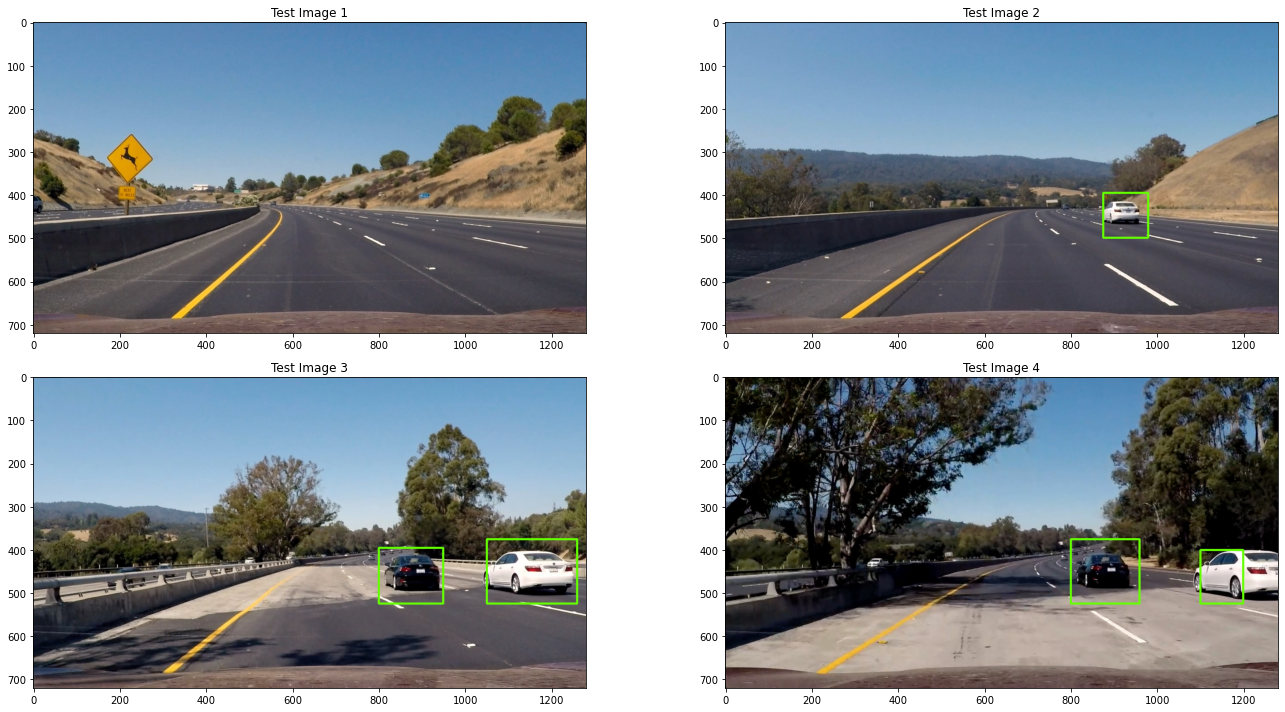

In [40]:
processor.visual_box(test_images, 'SVC')

In [41]:
project_output = 'output_videos\\project_clip_SVC.mp4'
clip1 = VideoFileClip("test_videos/test_video.mp4")
clip = clip1.fl_image(processor.vehicle_detection)
%time clip.write_videofile(project_output, audio=False)
clip.reader.close()

t:   0%|                                                                              | 0/38 [00:00<?, ?it/s, now=None]

object_id: 0
bbox0: (800, 395)
bbox1: (949, 524)

object_id: 1
bbox0: (1000, 400)
bbox1: (1199, 524)

Moviepy - Building video output_videos\project_clip_gr11.mp4.
Moviepy - Writing video output_videos\project_clip_gr11.mp4

object_id: 0
bbox0: (800, 395)
bbox1: (949, 524)

object_id: 1
bbox0: (1000, 400)
bbox1: (1199, 524)



t:   8%|█████▌                                                                | 3/38 [00:01<00:16,  2.19it/s, now=None]

object_id: 0
bbox0: (800, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1000, 400)
bbox1: (1199, 524)



t:  11%|███████▎                                                              | 4/38 [00:01<00:15,  2.26it/s, now=None]

object_id: 0
bbox0: (800, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1000, 400)
bbox1: (1199, 524)



t:  13%|█████████▏                                                            | 5/38 [00:02<00:14,  2.31it/s, now=None]

object_id: 0
bbox0: (800, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1000, 400)
bbox1: (1199, 524)



t:  16%|███████████                                                           | 6/38 [00:02<00:13,  2.32it/s, now=None]

object_id: 0
bbox0: (800, 395)
bbox1: (974, 524)

object_id: 1
bbox0: (1000, 395)
bbox1: (1199, 524)



t:  18%|████████████▉                                                         | 7/38 [00:03<00:13,  2.29it/s, now=None]

object_id: 0
bbox0: (800, 375)
bbox1: (974, 524)

object_id: 1
bbox0: (1000, 375)
bbox1: (1224, 524)



t:  21%|██████████████▋                                                       | 8/38 [00:03<00:14,  2.07it/s, now=None]

object_id: 0
bbox0: (800, 395)
bbox1: (974, 524)

object_id: 1
bbox0: (1000, 395)
bbox1: (1224, 524)



t:  24%|████████████████▌                                                     | 9/38 [00:04<00:15,  1.90it/s, now=None]

object_id: 0
bbox0: (800, 395)
bbox1: (974, 524)

object_id: 1
bbox0: (1000, 395)
bbox1: (1224, 524)



t:  26%|██████████████████▏                                                  | 10/38 [00:04<00:14,  1.92it/s, now=None]

object_id: 0
bbox0: (1000, 375)
bbox1: (1224, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (959, 524)



t:  29%|███████████████████▉                                                 | 11/38 [00:05<00:14,  1.93it/s, now=None]

object_id: 0
bbox0: (1000, 375)
bbox1: (1224, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (959, 524)



t:  32%|█████████████████████▊                                               | 12/38 [00:05<00:13,  1.94it/s, now=None]

object_id: 0
bbox0: (1000, 375)
bbox1: (1224, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (959, 524)



t:  34%|███████████████████████▌                                             | 13/38 [00:06<00:12,  1.97it/s, now=None]

object_id: 0
bbox0: (1020, 375)
bbox1: (1224, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (949, 524)



t:  37%|█████████████████████████▍                                           | 14/38 [00:06<00:12,  1.96it/s, now=None]

object_id: 0
bbox0: (800, 395)
bbox1: (959, 524)

object_id: 1
bbox0: (1000, 400)
bbox1: (1224, 524)



t:  39%|███████████████████████████▏                                         | 15/38 [00:07<00:11,  2.00it/s, now=None]

object_id: 0
bbox0: (800, 395)
bbox1: (949, 524)

object_id: 1
bbox0: (1000, 400)
bbox1: (1224, 524)



t:  42%|█████████████████████████████                                        | 16/38 [00:07<00:10,  2.04it/s, now=None]

object_id: 0
bbox0: (800, 395)
bbox1: (949, 499)

object_id: 1
bbox0: (1000, 400)
bbox1: (1224, 524)



t:  45%|██████████████████████████████▊                                      | 17/38 [00:08<00:10,  2.06it/s, now=None]

object_id: 0
bbox0: (800, 395)
bbox1: (949, 524)

object_id: 1
bbox0: (1020, 400)
bbox1: (1224, 524)



t:  47%|████████████████████████████████▋                                    | 18/38 [00:08<00:09,  2.07it/s, now=None]

object_id: 0
bbox0: (1020, 375)
bbox1: (1224, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (949, 524)



t:  50%|██████████████████████████████████▌                                  | 19/38 [00:09<00:09,  2.11it/s, now=None]

object_id: 0
bbox0: (800, 395)
bbox1: (949, 524)

object_id: 1
bbox0: (1020, 400)
bbox1: (1249, 524)

object_id: 2
bbox0: (460, 500)
bbox1: (579, 619)



t:  53%|████████████████████████████████████▎                                | 20/38 [00:09<00:08,  2.10it/s, now=None]

object_id: 0
bbox0: (800, 395)
bbox1: (949, 524)

object_id: 1
bbox0: (1020, 400)
bbox1: (1224, 524)

object_id: 2
bbox0: (520, 500)
bbox1: (639, 619)



t:  55%|██████████████████████████████████████▏                              | 21/38 [00:10<00:08,  2.10it/s, now=None]

object_id: 0
bbox0: (800, 395)
bbox1: (959, 524)

object_id: 1
bbox0: (1020, 400)
bbox1: (1249, 524)



t:  58%|███████████████████████████████████████▉                             | 22/38 [00:10<00:07,  2.10it/s, now=None]

object_id: 0
bbox0: (800, 395)
bbox1: (959, 524)

object_id: 1
bbox0: (1025, 400)
bbox1: (1249, 524)



t:  61%|█████████████████████████████████████████▊                           | 23/38 [00:11<00:07,  2.02it/s, now=None]

object_id: 0
bbox0: (800, 395)
bbox1: (959, 524)

object_id: 1
bbox0: (1025, 400)
bbox1: (1249, 524)



t:  63%|███████████████████████████████████████████▌                         | 24/38 [00:11<00:07,  1.99it/s, now=None]

object_id: 0
bbox0: (800, 395)
bbox1: (959, 524)

object_id: 1
bbox0: (1025, 400)
bbox1: (1249, 524)



t:  66%|█████████████████████████████████████████████▍                       | 25/38 [00:12<00:06,  2.01it/s, now=None]

object_id: 0
bbox0: (1020, 375)
bbox1: (1249, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (949, 524)



t:  68%|███████████████████████████████████████████████▏                     | 26/38 [00:12<00:05,  2.00it/s, now=None]

object_id: 0
bbox0: (1025, 375)
bbox1: (1249, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (949, 524)



t:  71%|█████████████████████████████████████████████████                    | 27/38 [00:13<00:05,  1.90it/s, now=None]

object_id: 0
bbox0: (1025, 375)
bbox1: (1249, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (959, 524)



t:  74%|██████████████████████████████████████████████████▊                  | 28/38 [00:13<00:05,  1.80it/s, now=None]

object_id: 0
bbox0: (1025, 375)
bbox1: (1249, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (949, 524)



t:  76%|████████████████████████████████████████████████████▋                | 29/38 [00:14<00:04,  1.87it/s, now=None]

object_id: 0
bbox0: (1025, 375)
bbox1: (1249, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (959, 524)



t:  79%|██████████████████████████████████████████████████████▍              | 30/38 [00:14<00:04,  1.84it/s, now=None]

object_id: 0
bbox0: (1025, 375)
bbox1: (1249, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (949, 524)



t:  82%|████████████████████████████████████████████████████████▎            | 31/38 [00:15<00:03,  1.87it/s, now=None]

object_id: 0
bbox0: (1025, 375)
bbox1: (1249, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (949, 524)



t:  84%|██████████████████████████████████████████████████████████           | 32/38 [00:15<00:03,  1.86it/s, now=None]

object_id: 0
bbox0: (1025, 375)
bbox1: (1249, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (949, 524)



t:  87%|███████████████████████████████████████████████████████████▉         | 33/38 [00:16<00:02,  1.85it/s, now=None]

object_id: 0
bbox0: (1025, 375)
bbox1: (1249, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (949, 524)



t:  89%|█████████████████████████████████████████████████████████████▋       | 34/38 [00:17<00:02,  1.57it/s, now=None]

object_id: 0
bbox0: (1025, 375)
bbox1: (1219, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (949, 524)



t:  92%|███████████████████████████████████████████████████████████████▌     | 35/38 [00:18<00:02,  1.40it/s, now=None]

object_id: 0
bbox0: (1025, 375)
bbox1: (1239, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (949, 524)



t:  95%|█████████████████████████████████████████████████████████████████▎   | 36/38 [00:18<00:01,  1.51it/s, now=None]

object_id: 0
bbox0: (800, 395)
bbox1: (959, 524)

object_id: 1
bbox0: (1040, 400)
bbox1: (1249, 524)



t:  97%|███████████████████████████████████████████████████████████████████▏ | 37/38 [00:19<00:00,  1.57it/s, now=None]

object_id: 0
bbox0: (800, 395)
bbox1: (959, 524)

object_id: 1
bbox0: (1040, 400)
bbox1: (1249, 524)



t: 100%|█████████████████████████████████████████████████████████████████████| 38/38 [00:20<00:00,  1.56it/s, now=None]

object_id: 0
bbox0: (1025, 375)
bbox1: (1249, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (949, 524)



object_id: 0
bbox0: (1040, 375)
bbox1: (1249, 524)

object_id: 1
bbox0: (800, 395)
bbox1: (949, 524)



Moviepy - Done !
Moviepy - video ready output_videos\project_clip_gr11.mp4
Wall time: 22.1 s


In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))